# Dealing with inbalanced Dataset

We have a dataset in realisitc proportion, we could oversemple but it will not be good.

We have a lot of IBD events created by Andrea and also a lot of radioactivity events. If we sort them in temporal order we get that there will be a little amount of IBD in all the radioactivity events, because it is more frequently have radioactivity events respect of IBD that are rare. 

So in order to train our ML-algorithm we could use generated IBD events and generated Radioactivity events, so in that cse we have basically the same amount of data and the inbalanced problem will disappear. After the training, we test with inbalaced dataset.

Basically we use a smote 

We will se if it work...

In [317]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

For the dataset we will use -unoscillated_IBD_userfile- and -radioactivity_userfile_7days- for the background.

In [318]:
file_BKG = up.open("radioactivity_userfile_7days.root")
file_IBD = up.open('../BrutalCuts/unoscillated_IBD_userfile.root') 
#file_IBD = up.open('ibd_userfile_7days.root') 


dataset_IBD_all = file_IBD['TRec'].arrays(library = 'np')
dataset_BKG = file_BKG['TRec'].arrays(library = 'np')

dataset_IBD = {}
for key in ['recx', 'recy', 'recz', 'm_QEn', 'm_triggerT']:
    dataset_IBD[key] = dataset_IBD_all[key]

en_fact = 0.92
dataset_IBD["m_QEn"] = dataset_IBD["m_QEn"]*en_fact 

Cheking if datasets are in temporal order


IBD:  25
BKG: 0
Cutted points:  50631    Total points:  99999


10600

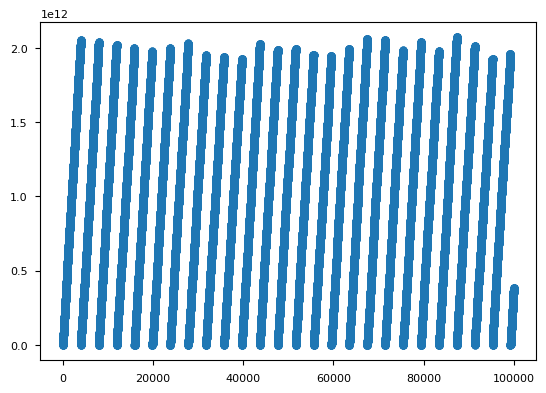

In [319]:
cut = 100000


delta_t_IBD = dataset_IBD['m_triggerT'][1:cut] - dataset_IBD['m_triggerT'][:cut-1]
mask_IBD = np.logical_and(delta_t_IBD < 0, True)

print("IBD: ",mask_IBD.sum())

delta_t_BKG = dataset_BKG['m_triggerT'][1:cut] - dataset_BKG['m_triggerT'][:cut-1]
mask_BKG = np.logical_and(delta_t_BKG < 0, True)

print("BKG:", mask_BKG.sum())

#Plot of IBDs because they are not in temporal order
plt.scatter(np.arange(cut),dataset_IBD['m_triggerT'][:cut])

mask_dt_IBD = np.logical_and(delta_t_IBD > 5*220e3, True)
print("Cutted points: ", mask_dt_IBD.sum(), " ", ' Total points: ', mask_dt_IBD.shape[0])

mask_dt_BKG = np.logical_and(delta_t_BKG < 5*220e3, True)
mask_dt_BKG.sum()


From the plot of $\Delta t$ we can say that BKG events are much more close then IBDs, so using the 5 * $\tau$ cut limit, we exclude much more points.

We have to say this plot show only the i+1 - i, instead the featur table calculate olao the other i+j with j = {1, .. , N} 

# Creation of two tables of features: one for IBD events and one for BKG, keeping them separately

The feature table will have those features ($\Delta t$, $\Delta r$, $E_p$, $E_d$,$R_{prompt}$, $R_{delayed}$, $Label$)

In [320]:
from numba import njit, prange

In [321]:
@njit(parallel = True)
def create_features_handle(x,y,z,E,t,expon_time_cut = 5 * 220e3):

    n = x.shape[0] - 1
      
    delta_time = n*[np.zeros(0)]
    delta_radius = n*[np.zeros(0)]
    E_pro = n*[np.zeros(0)]
    E_del = n*[np.zeros(0)] 
    R_prompt = n*[np.zeros(0)]
    R_delayed = n*[np.zeros(0)]

    for i in prange(x.shape[0] - 1):

        mask = np.logical_and(t>t[i], (t - t[i]) < expon_time_cut)
        to_loop = np.nonzero(mask)[0] 

        for t_index in range(len(to_loop)):
            j = to_loop[t_index] 

            if (t[j] - t[i]) < expon_time_cut:
                delta_time[i] = np.append(delta_time[i], t[j] - t[i])
                delta_radius[i] = np.append(delta_radius[i],np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2))
                E_pro[i] = np.append(E_pro[i], E[i])
                E_del[i] = np.append(E_del[i], E[j])
                R_prompt[i] = np.append(R_prompt[i],np.sqrt((x[i])**2 + (y[i])**2 + (z[i])**2))
                R_delayed[i] = np.append(R_delayed[i],np.sqrt((x[j])**2 + (y[j])**2 + (z[j])**2))

            else:
                print(i, j, t[j] - t[i], 'Qualcosa non va')
                break

    return delta_time, delta_radius, E_pro, E_del, R_prompt, R_delayed

from iteration_utilities import deepflatten

# Funzione per fare un flatten dell'output di Numba
def create_features(x,y,z,E,t, expon_time_cut = 5 * 220e3):
    res = create_features_handle(x,y,z,E,t, expon_time_cut)
    out = []
    for vec in res:
        out.append(np.asarray(list(deepflatten(vec))))  
    return out


## I'll create the feature for IBD events

In [322]:
features_IBD = {"delta_time": np.array([]), #Questa è vuota 
            "delta_radius": np.array([]),
            "E_pro": np.array([]),
            "E_del": np.array([]),
            "R_prompt": np.array([]),
            "R_delayed": np.array([])} 

cut = 100000
features_IBD["delta_time"],features_IBD["delta_radius"],features_IBD["E_pro"],features_IBD["E_del"],features_IBD["R_prompt"],features_IBD["R_delayed"]  = create_features(
    dataset_IBD["recx"][:cut],
    dataset_IBD["recy"][:cut],
    dataset_IBD["recz"][:cut],
    dataset_IBD["m_QEn"][:cut],
    dataset_IBD["m_triggerT"][:cut])




In [323]:
print(features_IBD["delta_time"].shape[0])
print(features_IBD["delta_radius"].shape[0])
print(features_IBD["E_pro"].shape[0])
print(features_IBD["E_del"].shape[0])
print(features_IBD["R_prompt"].shape[0])
print(features_IBD["R_delayed"].shape[0])

47740
47740
47740
47740
47740
47740


Ne sono 47mila eprchè a casua dell'exponential time cut, priaticamente tra tutte le coppie possibili per l'IBD viene selzionata quasi sempre l'evento i-esimo e il successivo.
Alcune volte non viene selezionato proprio nulla.

## Now for the BKG

In [324]:
features_BKG = {"delta_time": np.array([]),
                "delta_radius": np.array([]),
                "E_pro": np.array([]),
                "E_del": np.array([]),
                "R_prompt": np.array([]),
                "R_delayed": np.array([])}

cut = 100000

features_BKG["delta_time"],features_BKG["delta_radius"],features_BKG["E_pro"],features_BKG["E_del"],features_BKG["R_prompt"],features_BKG["R_delayed"] = create_features(
        dataset_BKG["recx"][:cut],
        dataset_BKG["recy"][:cut],
        dataset_BKG["recz"][:cut],
        dataset_BKG["m_QEn"][:cut],
        dataset_BKG["m_triggerT"][:cut])

In [325]:
print(features_BKG["delta_time"].shape[0])
print(features_BKG["delta_radius"].shape[0])
print(features_BKG["E_pro"].shape[0])
print(features_BKG["E_del"].shape[0])
print(features_BKG["R_prompt"].shape[0])
print(features_BKG["R_delayed"].shape[0])

11237
11237
11237
11237
11237
11237


# Plots before the cut

Delta time

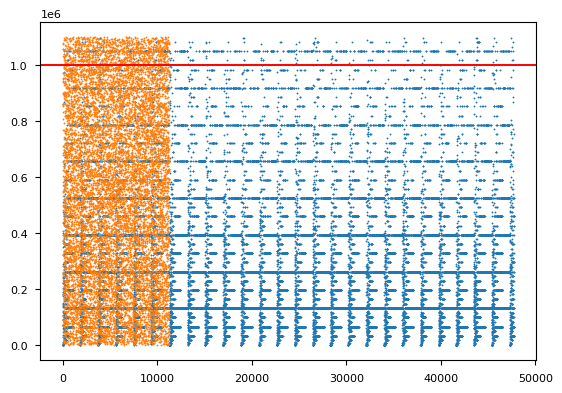

In [326]:
plt.scatter(np.arange(features_IBD["delta_time"].shape[0]), features_IBD["delta_time"], s=1)
plt.scatter(np.arange(features_BKG["delta_time"].shape[0]), features_BKG["delta_time"], s=1)
plt.axhline(1e6, c = 'red')

Delta radius

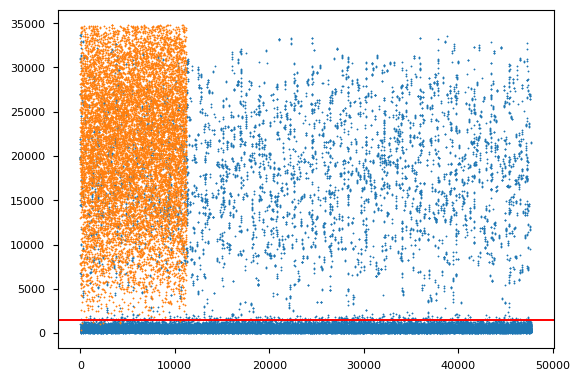

In [327]:
plt.scatter(np.arange(features_IBD["delta_radius"].shape[0]), features_IBD["delta_radius"], s=1)
plt.scatter(np.arange(features_BKG["delta_radius"].shape[0]), features_BKG["delta_radius"], s=1)
plt.axhline(1500, c = 'red')

# Running the cutting algorithm for both IBD and BKG

The follow cell will contein the cutting algoritm

In [330]:
@njit(parallel = True) 
#delta time in nanoseconds
#delta radius in mm
def selection(dt,dr,E_pro,E_del, delta_time = 1e6, delta_radius = 1500, min_energy_prompt = 0.7,max_energy_prompt = 12, min_energy_delay = 1.9, max_energy_delay = 2.5, min_energy_delay_carb = 4.4, max_energy_delay_carb = 5.5):
    prompt_columns = np.zeros(dt.shape)
    delay_columns = np.zeros(dt.shape)
    delay_columns_carb = np.zeros(dt.shape)
    for i in prange(dt.shape[0]):
        if dt[i] < delta_time: #It is not necessery
            if dr[i] < delta_radius: 
                if E_pro[i]>= min_energy_prompt and E_pro[i]<= max_energy_prompt:
                    if E_del[i]>= min_energy_delay and E_del[i]<= max_energy_delay:
                        prompt_columns[i] = 1
                        delay_columns[i] = 1
                    if E_del[i]>= min_energy_delay_carb and E_del[i]<= max_energy_delay_carb:
                        prompt_columns[i] = 1
                        delay_columns_carb[i] = 1
    return prompt_columns,delay_columns,delay_columns_carb

## IBD selection

In [331]:
prompt_columns_IBD, delay_columns_IBD, delay_columns_carb_IBD = selection(features_IBD["delta_time"],
                                                                           features_IBD["delta_radius"],
                                                                           features_IBD["E_pro"],
                                                                           features_IBD["E_del"])

In [332]:
print(prompt_columns_IBD.sum(), prompt_columns_IBD.shape[0])
print(delay_columns_carb_IBD.sum(),delay_columns_carb_IBD.shape[0])
print(delay_columns_IBD.sum(),delay_columns_IBD.shape[0])



print("Accuracy: ", ((prompt_columns_IBD.sum() + delay_columns_carb_IBD.sum() + delay_columns_IBD.sum())  / (prompt_columns_IBD.shape[0] * 2)) * 100)

40378.0 47740
480.0 47740
39898.0 47740
Accuracy:  84.57896941767909


## BKG selection

In [333]:
prompt_columns_BKG, delay_columns_BKG, delay_columns_carb_BKG = selection(features_BKG["delta_time"],
                                                                           features_BKG["delta_radius"],
                                                                           features_BKG["E_pro"],
                                                                           features_BKG["E_del"])

In [334]:
print(prompt_columns_BKG.sum(), prompt_columns_BKG.shape[0])
print(delay_columns_carb_BKG.sum(),delay_columns_carb_BKG.shape[0])
print(delay_columns_BKG.sum(),delay_columns_BKG.shape[0])



print("Accuracy: ", ((prompt_columns_BKG.sum() + delay_columns_carb_BKG.sum() + delay_columns_BKG.sum())  / (prompt_columns_BKG.shape[0] * 2)) * 100)

1.0 11237
0.0 11237
1.0 11237
Accuracy:  0.008899172376968943


In [335]:
print(((prompt_columns_BKG.sum() + delay_columns_BKG.sum() + delay_columns_carb_BKG.sum())/cut) * 100)

0.002


## Plots after the cuts

(array([  0.,   0.,   1.,   0.,   1.,  22.,  57., 119., 154.,  95.,  26.,
          5.,   0.]),
 array([4.4       , 4.48461538, 4.56923077, 4.65384615, 4.73846154,
        4.82307692, 4.90769231, 4.99230769, 5.07692308, 5.16153846,
        5.24615385, 5.33076923, 5.41538462, 5.5       ]),
 <BarContainer object of 13 artists>)

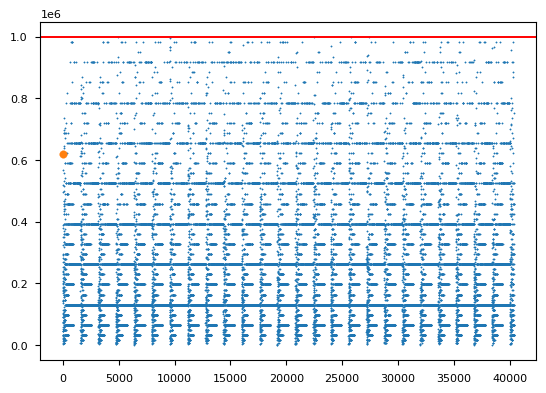

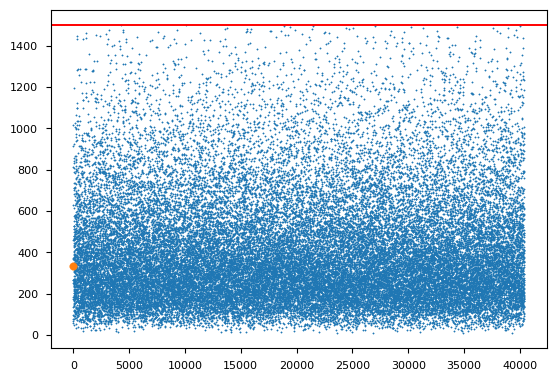

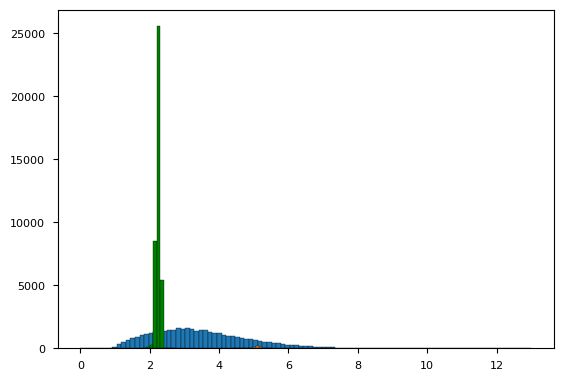

In [372]:
fig1 = plt.figure()
plt.scatter(np.arange(prompt_columns_IBD.sum()), features_IBD["delta_time"][prompt_columns_IBD == 1], s=1)
plt.scatter(np.arange(prompt_columns_BKG.sum()), features_BKG["delta_time"][prompt_columns_BKG == 1], s=30)
plt.axhline(1e6, c = 'red')

fig2 = plt.figure()
plt.scatter(np.arange(prompt_columns_IBD.sum()), features_IBD["delta_radius"][prompt_columns_IBD == 1], s=1)
plt.scatter(np.arange(prompt_columns_BKG.sum()), features_BKG["delta_radius"][prompt_columns_BKG == 1], s=30)
plt.axhline(1500, c = 'red')

fig3 = plt.figure()
plt.hist(features_IBD["E_pro"][prompt_columns_IBD == 1], np.linspace(0,13,100))
plt.hist(features_IBD["E_del"][delay_columns_IBD == 1], np.linspace(1.8,2.7,10), color= "green")
plt.hist(features_IBD["E_del"][delay_columns_carb_IBD == 1], np.linspace(4.4,5.5,14))

# Merging the IBD and BKG tables

In [336]:
def combine_dict(d1, d2):
    combined = {}
    for k in set(d1.keys()) | set(d2.keys()):
        if k in d1 and k in d2 and isinstance(d1[k], np.ndarray) and isinstance(d2[k], np.ndarray):
            combined[k] = np.concatenate([d1[k], d2[k]])
        elif k in d1:
            combined[k] = d1[k]
        else:
            combined[k] = d2[k]
    
    label = np.concatenate([np.full_like(d1.get(k, []), 1), np.full_like(d2.get(k, []), 0)])
    return {**combined, 'Label': label}

In [337]:
all_feature = combine_dict(features_IBD,features_BKG)

In [338]:
print(all_feature)

{'E_del': array([2.19753385, 2.66693759, 2.26439619, ..., 0.51890534, 0.27365047,
       0.15605544]), 'delta_time': array([2.525340e+05, 1.400000e+01, 3.727530e+05, ..., 2.000000e+03,
       9.615080e+05, 1.083151e+06]), 'E_pro': array([2.28723383, 2.28723383, 2.28723383, ..., 0.16010985, 1.91592062,
       0.22029625]), 'R_delayed': array([16664.08203125,  8603.37304688,  8619.1875    , ...,
       17399.        , 16078.75976562, 14418.36621094]), 'R_prompt': array([17318.61523438, 17318.61523438, 17318.61523438, ...,
       15486.35742188, 17399.        , 14068.36425781]), 'delta_radius': array([ 1015.95275879, 19719.31054688, 19869.32421875, ...,
        6528.97900391, 20547.859375  , 23925.40820312]), 'Label': array([1., 1., 1., ..., 0., 0., 0.])}


In [339]:
# ottieni il numero di righe in ogni array
n_rows = all_feature['E_del'].shape[0]

# crea un nuovo ordine casuale degli indici delle righe
new_order = np.random.permutation(n_rows)

# estrai le righe nei nuovi indici
for key in all_feature:
    all_feature[key] = all_feature[key][new_order]


In [340]:

print(all_feature)
print(all_feature['Label'].sum())

{'E_del': array([2.25510073, 2.3105886 , 2.18003082, ..., 1.75799274, 2.18059921,
       2.19129229]), 'delta_time': array([ 65536.,  65536., 262144., ..., 393216., 262144., 671744.]), 'E_pro': array([2.75769639, 2.94170117, 2.21061277, ..., 2.24487805, 3.00975108,
       1.15527487]), 'R_delayed': array([14612.08984375, 16914.47851562, 11513.07910156, ...,
       15275.12597656, 14631.70605469, 10558.83300781]), 'R_prompt': array([14719.48144531, 17065.73828125, 15755.08789062, ...,
       13770.56933594, 15124.95703125, 10811.55761719]), 'delta_radius': array([  435.66314697,   376.92938232, 23803.55273438, ...,
       27857.58203125,   540.58752441,   276.55371094]), 'Label': array([1., 1., 1., ..., 1., 1., 1.])}
47740.0


# Experimenting

## Cut Algorithm -- Da finire

In [341]:
prompt_columns, delay_columns, delay_columns_carb = selection(all_data["delta_time"],
                                                              all_data["delta_radius"],
                                                              all_data["E_pro"],
                                                              all_data["E_del"])
#Da finire

In [342]:
print(((prompt_columns.sum() + delay_columns.sum() + delay_columns_carb.sum())/cut) * 100)

80.758


## XGBClassifier

In [343]:
all_feature.keys()

dict_keys(['E_del', 'delta_time', 'E_pro', 'R_delayed', 'R_prompt', 'delta_radius', 'Label'])

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

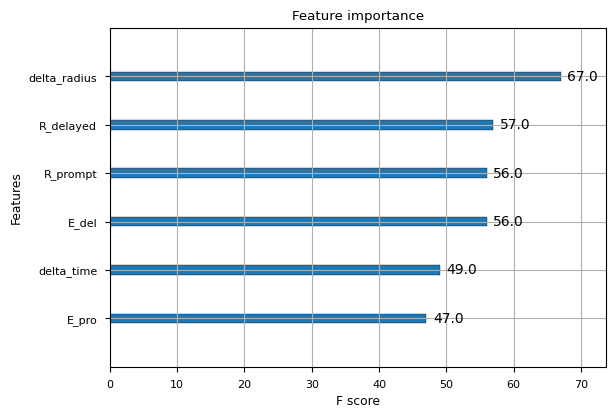

In [387]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = np.concatenate((all_feature['E_del'], all_feature['delta_time'], all_feature['E_pro'], all_feature['R_delayed'], all_feature['R_prompt'], all_feature['delta_radius']), axis=0).reshape(-1,6)
Y = all_feature['Label'].reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)


# Lista dei nomi delle features
feature_names = list(all_feature.keys())
feature_names.pop()

# Creazione oggetto DMatrix per i dati di addestramento e di test
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

# Creazione modello XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
num_rounds = 10
xgb_model = xgb.train(params, dtrain, num_rounds)

# Visualizzazione dell'importanza delle feature
xgb.plot_importance(xgb_model)



# TODO list

[ v ] Create two distinct features' tables (one for 100.000 unoscillated IBDs, one for the 7days radioactivity dataset). Remember to add R_ptompt and R_delayed to the stored features


[ v ] Run your standard selection on the two tables separately to estimate efficiency and purity.


[ v ] Remember to remove the "label == 1" from your function.


[ ] Concatenate the two tables, shuffle the order of the rows and start experimenting. Check the performances of XGBoost compared to the standard selection.

For any problem, write us and we can discuss about it! Have a nice weekend